In [1]:
from _utils import *
from _polychrom import *

2024-10-24 13:40:32.489575: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-24 13:40:32.950517: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F AVX512_VNNI, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def load_polymer_simulation(polymer_directory, num_monomers=None):
    items = os.listdir(polymer_directory)
    # Filter out the items that are not directories
    folders = [item for item in items if os.path.isdir(os.path.join(polymer_directory, item))]
    polymer_folders = [os.path.join(polymer_directory, f) for f in folders if f[:8] == 'template']

    def load_polymer_hdf5(polymer_directory, num_monomers):
        URIs = polychrom.hdf5_format.list_URIs(polymer_directory)
        if num_monomers is None:
            [num_monomers, _] = polychrom.hdf5_format.load_URI(URIs[0])["pos"].shape
        num_polymers = len(URIs)
        polys = np.full((num_monomers, 3, num_polymers), np.nan)
        dmaps = np.full((num_monomers, num_monomers, num_polymers), np.nan)
        for iURI, URI in enumerate(URIs):
            data = polychrom.hdf5_format.load_URI(URI)
            xyz = data["pos"]
            polys[:, :, iURI] = xyz[:num_monomers, :]
            dmaps[:, :, iURI] = squareform(pdist(xyz[:num_monomers, :]))
        return polys, dmapsb

    polymer_folders.sort()

    polys_list, dmaps_list = [], []
    for f in polymer_folders:
        polys, dmaps = load_polymer_hdf5(f, num_monomers)
        polys_list.append(polys)
        dmaps_list.append(dmaps)
    
    polys_tensor = np.concatenate(polys_list, axis=2)
    dmaps_tensor = np.concatenate(dmaps_list, axis=2)
    
    return polys_tensor, dmaps_tensor 

In [3]:
def load_polymer_hdf5(polymer_directory, num_monomers):
    URIs = polychrom.hdf5_format.list_URIs(polymer_directory)
    if num_monomers is None:
        [num_monomers, _] = polychrom.hdf5_format.load_URI(URIs[0])["pos"].shape
    num_polymers = len(URIs)
    polys = np.full((num_monomers, 3, num_polymers), np.nan)
    dmaps = np.full((num_monomers, num_monomers, num_polymers), np.nan)
    for iURI, URI in tqdm(enumerate(URIs)):
        data = polychrom.hdf5_format.load_URI(URI)
        xyz = data["pos"]
        polys[:, :, iURI] = xyz[:num_monomers, :]
        dmaps[:, :, iURI] = squareform(pdist(xyz[:num_monomers, :]))
    return polys, dmaps

In [4]:
esc_dir = '/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/md_results/20241023_Sox9_esc_BEend_BEstronger_Monomers800'
cnc_dir = '/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/md_results/20241023_Sox9_cnc_BEend_BEstronger_Monomers800'

In [5]:
esc_polys, esc_dmaps = load_polymer_hdf5(esc_dir, 800)
cnc_polys, cnc_dmaps = load_polymer_hdf5(cnc_dir, 800)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [6]:
import matplotlib

In [10]:
esc_median_map = np.nanmedian(esc_dmaps, axis=2)

In [11]:
contact_threshold = np.mean(np.diag(esc_median_map, 1))
contact_threshold

1.0032159651230028

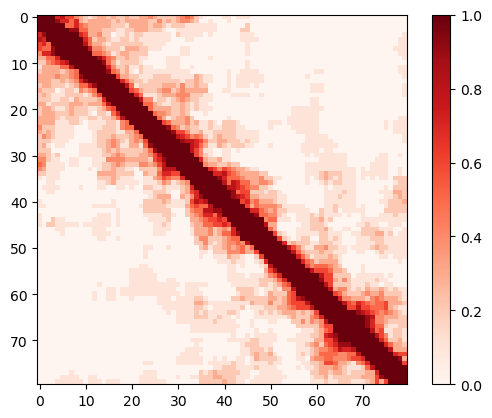

In [16]:
plt.imshow(np.mean(esc_dmaps[:80, :80] < 3, axis=2), cmap='Reds')
plt.colorbar()

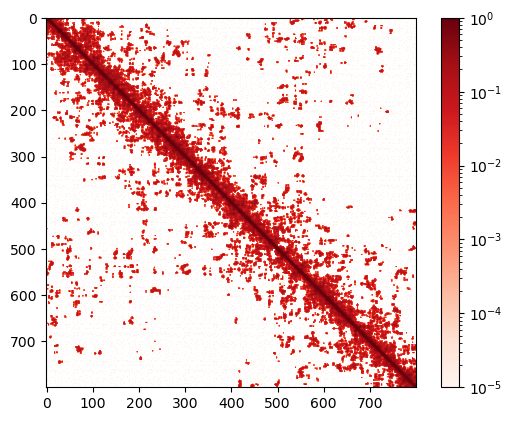

In [14]:
norm = matplotlib.colors.LogNorm(vmin=1e-5, vmax=1e-0)
plt.imshow(np.mean(esc_dmaps[:800, :800] < 3, axis=2), cmap='Reds', norm=norm)
plt.colorbar()

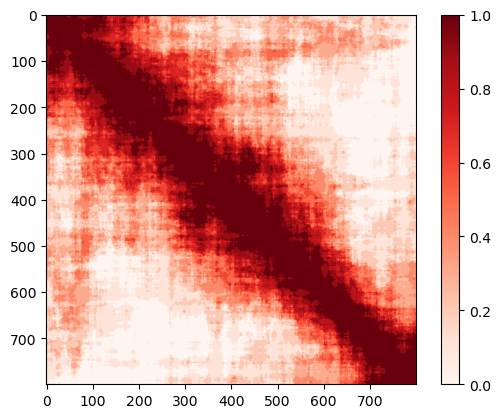

In [130]:
plt.imshow(np.mean(cnc_dmaps[:800, :800] < 15, axis=2), cmap='Reds')
plt.colorbar()

In [67]:
esc_dmaps.shape

(5000, 5000, 100)

In [121]:
# Keep stacking maps every 80 monomers
esc_dmaps_list = []
cnc_dmaps_list = []

esc_median_dmaps = np.median(esc_dmaps, axis=2)
cnc_median_dmaps = np.median(cnc_dmaps, axis=2)

for i in range(0, esc_median_dmaps.shape[0]-801, 801):
    esc_dmaps_list.append(esc_median_dmaps[i:i+801, i:i+801])
    cnc_dmaps_list.append(cnc_median_dmaps[i:i+801, i:i+801])

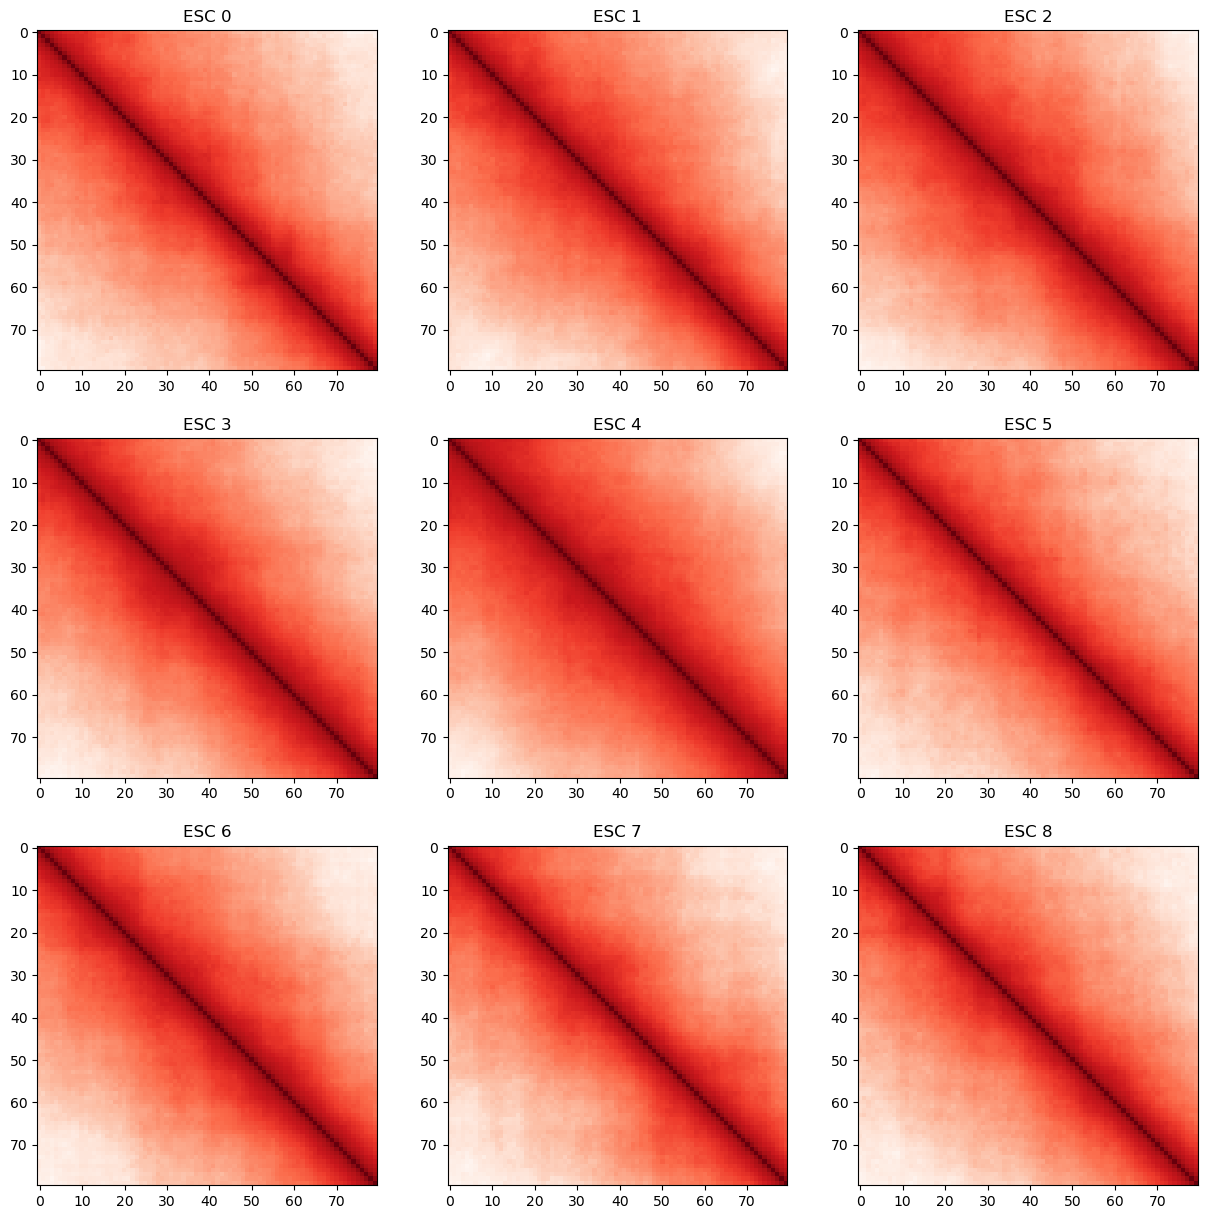

In [69]:
# Plot the first 9 maps
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
for i, ax in enumerate(axs.flat):
    ax.imshow(esc_dmaps_list[i], cmap='Reds_r')
    ax.set_title(f'ESC {i}')

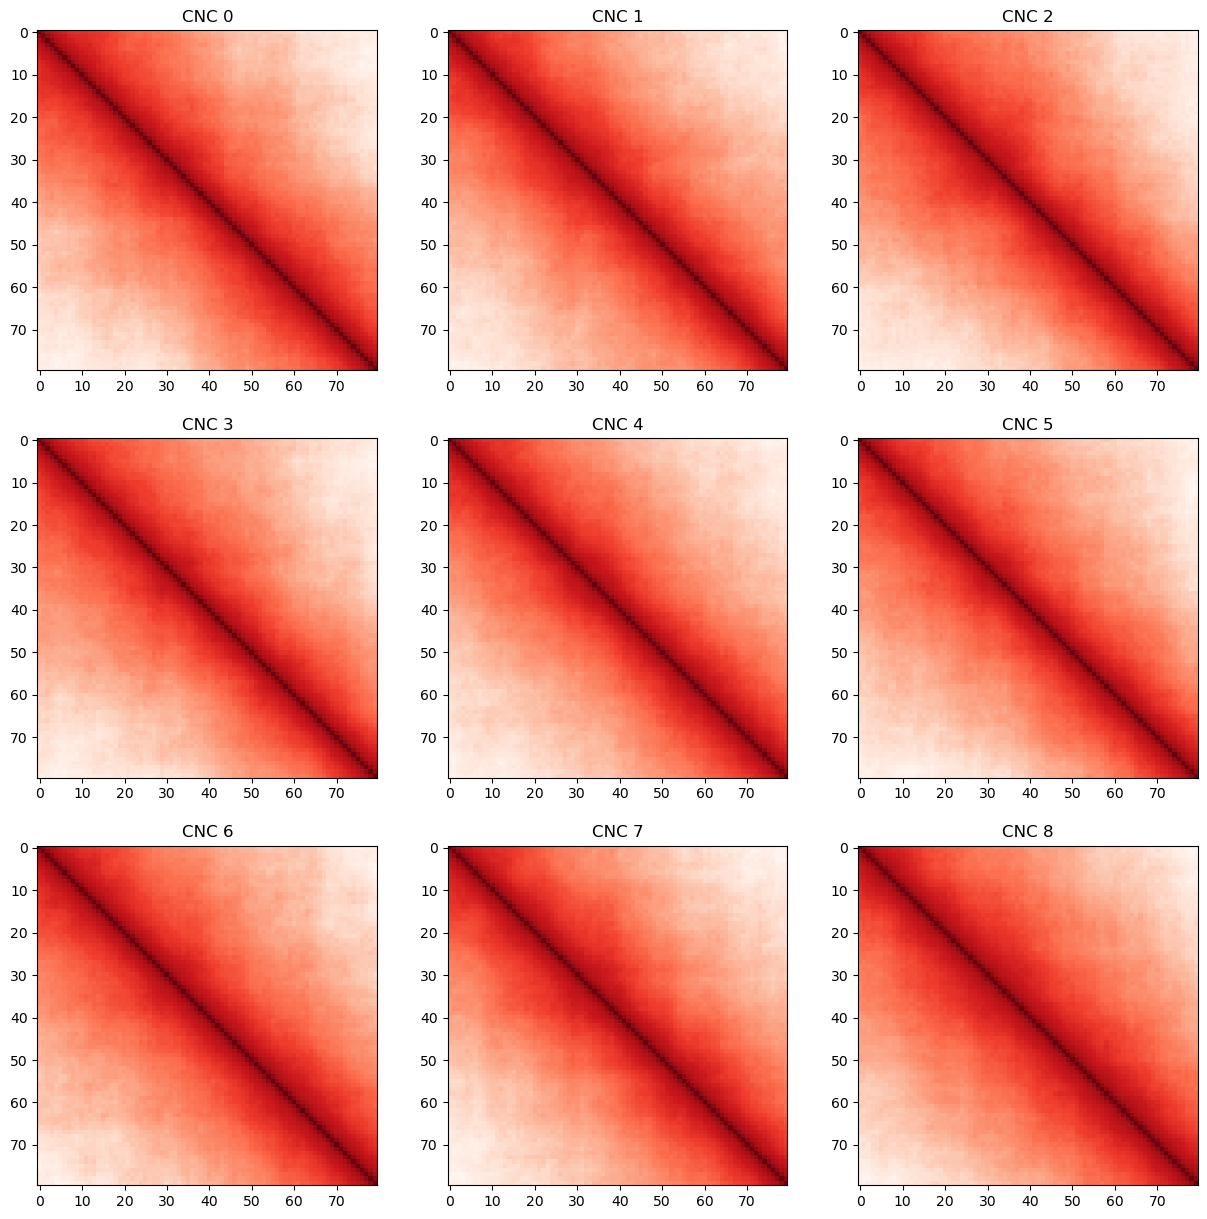

In [70]:
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
for i, ax in enumerate(axs.flat):
    ax.imshow(cnc_dmaps_list[i], cmap='Reds_r')
    ax.set_title(f'CNC {i}')